## Imports

In [ ]:
!pip install -U torch==1.13.0 torchtext==0.14.0 torchdata==0.5.0

# Reload environment
exit()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.1/890.1 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 75.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 92.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 61.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 72.7 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.3.0+cu121
    Uninstalling torch-2.3.0+cu121:
      Successfully uninstalled torch-2.3.0+cu121
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.18.0
    Uninstalling torchtext-0.18.0:
      Successfully uninstalled torchtext-0.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are ins

In [ ]:
import pandas as pd
import gzip
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch
import random
import time
import os
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer
from torch.utils.data import Sampler, Dataset
from torchdata.datapipes.iter import IterableWrapper, FileOpener
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/Neural_Network/HW5'

/content/drive/MyDrive/Neural_Network/HW5


## Download Dataset

In [ ]:
!wget https://jmcauley.ucsd.edu/data/amazon_v2/categoryFilesSmall/Industrial_and_Scientific_5.json.gz --no-check-certificate

--2024-06-03 11:36:14--  https://jmcauley.ucsd.edu/data/amazon_v2/categoryFilesSmall/Industrial_and_Scientific_5.json.gz
Resolving jmcauley.ucsd.edu (jmcauley.ucsd.edu)... 137.110.160.73
Connecting to jmcauley.ucsd.edu (jmcauley.ucsd.edu)|137.110.160.73|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 10994038 (10M) [application/x-gzip]
Saving to: ‘Industrial_and_Scientific_5.json.gz’

Industrial_and_Scie 100%[===================>]  10.48M  6.79MB/s    in 1.5s    

2024-06-03 11:36:16 (6.79 MB/s) - ‘Industrial_and_Scientific_5.json.gz’ saved [10994038/10994038]



In [ ]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

In [ ]:
def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

In [ ]:
df = getDF('/content/drive/MyDrive/Neural-Network/HW5/Industrial_and_Scientific_5.json.gz')

In [ ]:
df['overall'] = (df['overall'] - 1) * (4 / (5 - 1))
df['overall'] = df['overall'].astype(int)
columns_to_keep = ['reviewText', 'overall']
df = df[columns_to_keep]

In [ ]:
df.head()

,reviewText,overall
0,This worked really well for what I used it for...,4
1,Fast cutting and good adheasive.,4
2,Worked great for my lapping bench. I would li...,4
3,As advertised,3
4,seems like a pretty good value as opposed to b...,4


In [ ]:
df.to_csv('Industrial_and_Scientific_5.csv')

# General Settings

In [ ]:
RANDOM_SEED = 123
torch.manual_seed(RANDOM_SEED)

VOCABULARY_SIZE = 40000
LEARNING_RATE = 0.005
BATCH_SIZE = 64
NUM_EPOCHS = 15
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

EMBEDDING_DIM = 128
HIDDEN_DIM = 256
NUM_CLASSES = 5

# Dataset

In [ ]:
datapipe = IterableWrapper(["Industrial_and_Scientific_5.csv"])
datapipe = FileOpener(datapipe, mode='b')
datapipe = datapipe.parse_csv(skip_lines=1)

In [ ]:
print(list(datapipe)[0])

['0', "This worked really well for what I used it for. So for my purposes it is getting full marks. This is an all around great, durable, and afforable sandpaper.\n\nPros:\n-Grit cuts really fast and evenly. No random deep scratches like I have seen in some cheaper paper\n-Didn't even have a hint of clogging up.\n-The adhesive is just what I needed. No permanent, but wasn't going anywhere.\n\nCons:\n-None", '4']


# Split Dataset into Train/Validation/Test

In [ ]:
# Get the number of rows in dataset
N_ROWS = len(list(datapipe))
print(N_ROWS)

# Split into training and val datapipes early on. Will build vocabulary from training datapipe only.
train_dp, valid_dp, test_dp = datapipe.random_split(total_length=N_ROWS, weights={"train": 0.8, "valid": 0.1, "test": 0.1}, seed=0)
print(f'Num Train: {len(list(train_dp))}')
print(f'Num Validate: {len(list(valid_dp))}')
print(f'Num Test: {len(list(test_dp))}')

77071
Num Train: 61657
Num Validate: 7707
Num Test: 7707


# Build the Vocabulary

Build the vocabulary based on the top `VOCABULARY_SIZE` words. **build_vocab_from_iterator()** collects the most frequent tokens from the iterator **yield_tokens(train_datapipe)**, and adds special tokens at the begginning w/o changing the order of supplied tokens.

In [ ]:
# Based on tutorial at https://www.youtube.com/watch?v=CrS-LFXEiyk
tokenizer = get_tokenizer(tokenizer='spacy', language='en_core_web_sm')

def yield_tokens(data_iter):
    for _, text , _ in data_iter:
        yield tokenizer(text)

def get_vocab(train_datapipe):
    vocab = build_vocab_from_iterator(yield_tokens(train_datapipe), specials=["<UNK>", "<PAD>"], max_tokens=VOCABULARY_SIZE)
    vocab.set_default_index(vocab["<UNK>"])
    return vocab

In [ ]:
vocab = get_vocab(train_dp)

In [ ]:
print("Vocabulary size: ", len(vocab))
# Tokens corresponding to the first 10 indices (0, 1, ..., 9):
print(vocab.get_itos()[:10]) # itos = integer-to-string

Vocabulary size:  40000
['<UNK>', '<PAD>', '.', 'the', ',', 'I', 'to', 'and', 'a', 'it']


PyTorch RNNs can deal with arbitrary lengths due to dynamic graphs, but padding is necessary for padding sequences to the same length in a given minibatch so we can store those in an array.

**Converting a string to an integer:**

In [ ]:
# A direct way
print(f"the: {vocab['the']}")

# And an indirect way, using get_stoi() to get a dictionary of tokens and values
print(f"the: {vocab.get_stoi()['the']}") # stoi = string-to-integer

# What is the padding value?
print(f"<PAD>: {vocab['<PAD>']}")
PADDING_VALUE=vocab['<PAD>']

the: 3
the: 3
<PAD>: 1


In [ ]:
text_transform = lambda x: [vocab[token] for token in tokenizer(x)]
label_transform = lambda x: int(x)

# Print out the output of text_transform
print("input to the text_transform:", "here is an example")
print("output of the text_transform:", text_transform("here is an example"))

input to the text_transform: here is an example
output of the text_transform: [347, 11, 71, 1144]


In [ ]:
vocab_itos = vocab.get_itos()
vec_vocab_itos = np.vectorize(lambda x: vocab_itos[x])
vec_vocab_itos([1, 2, 3, 4, 5])

array(['<PAD>', '.', 'the', ',', 'I'], dtype='<U5')

# Define Data Loaders

In [ ]:
def collate_batch(batch):
   text_list, label_list = [], []
   for (_, _text, _label) in batch:
        processed_text = torch.tensor(text_transform(_text))
        text_list.append(processed_text)
        label_list.append(label_transform(_label))
   return pad_sequence(text_list, padding_value=PADDING_VALUE).to(DEVICE), torch.tensor(label_list).to(DEVICE)

In [ ]:
# Create our own sampler, to ensure we function with multiple worker threads
class BatchSamplerSimilarLength(Sampler):
    def __init__(self, dataset, batch_size, indices=None, shuffle=True):
        self.batch_size = batch_size
        self.shuffle = shuffle
        # get the indices and length
        self.indices = [(i, len(tokenizer(s[0]))) for i, s in enumerate(dataset)]
        # if indices are passed, then use only the ones passed (for ddp)
        if indices is not None:
            self.indices = torch.tensor(self.indices)[indices].tolist()

    def __iter__(self):
        if self.shuffle:
            random.shuffle(self.indices)

        pooled_indices = []
        # create pool of indices with similar lengths
        for i in range(0, len(self.indices), self.batch_size * 100):
          pooled_indices.extend(sorted(self.indices[i:i + self.batch_size * 100], key=lambda x: x[1]))
        self.pooled_indices = [x[0] for x in pooled_indices]

        # Comment in for validation
        #self.pooled_lengths = [x[1] for x in pooled_indices]
        #print(self.pooled_lengths)
        #print(self.pooled_indices)

        # yield indices for current batch
        batches = [self.pooled_indices[i:i + self.batch_size] for i in
                   range(0, len(self.pooled_indices), self.batch_size)]

        if self.shuffle:
            random.shuffle(batches)
        for batch in batches:
            yield batch

    def __len__(self):
        return len(self.pooled_indices) // self.batch_size

In [ ]:
train_dp_list = list(train_dp)
valid_dp_list = list(valid_dp)
test_dp_list = list(test_dp)

train_loader = DataLoader(train_dp_list,
                          batch_sampler=BatchSamplerSimilarLength(dataset = train_dp_list,
                                                                  batch_size=BATCH_SIZE),
                          collate_fn=collate_batch)
valid_loader = DataLoader(valid_dp_list,
                          batch_sampler=BatchSamplerSimilarLength(dataset = valid_dp_list,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=False),
                          collate_fn=collate_batch)
test_loader = DataLoader(test_dp_list,
                          batch_sampler=BatchSamplerSimilarLength(dataset = test_dp_list,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=False),
                          collate_fn=collate_batch)

In [ ]:
text_batch, label_batch = next(iter(train_loader))
print(text_batch.size())
print(label_batch.size())

torch.Size([250, 64])
torch.Size([64])


Testing the iterators (note that the number of rows depends on the longest document in the respective batch):

In [ ]:
print('Train')
for text_batch, label_batch in train_loader:
    print(f'Text matrix size: {text_batch.size()}')
    print(f'Target vector size: {label_batch.size()}')
    break

print('\nValid:')
for text_batch, label_batch in valid_loader:
    print(f'Text matrix size: {text_batch.size()}')
    print(f'Target vector size: {label_batch.size()}')
    break

print('\nTest:')
for text_batch, label_batch in test_loader:
    print(f'Text matrix size: {text_batch.size()}')
    print(f'Target vector size: {label_batch.size()}')
    break

Train
Text matrix size: torch.Size([551, 64])
Target vector size: torch.Size([64])

Valid:
Text matrix size: torch.Size([211, 64])
Target vector size: torch.Size([64])

Test:
Text matrix size: torch.Size([259, 64])
Target vector size: torch.Size([64])


In [ ]:
print(text_batch)

tensor([[2749,  509,   28,  ...,  228,   91,   36],
        [ 232,   40, 2466,  ...,  218,  465,   57],
        [  16,   17,    1,  ...,    2, 1336,    6],
        ...,
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1]], device='cuda:0')


In [ ]:
print(vec_vocab_itos(text_batch.to("cpu")))

[['Absolutely' 'Worked' 'The' ... 'As' 'Great' 'good']
 ['love' 'well' 'alternative' ... 'expected' 'shop' 'just']
 ['this' 'with' '<PAD>' ... '.' 'towels' 'to']
 ...
 ['<PAD>' '<PAD>' '<PAD>' ... '<PAD>' '<PAD>' '<PAD>']
 ['<PAD>' '<PAD>' '<PAD>' ... '<PAD>' '<PAD>' '<PAD>']
 ['<PAD>' '<PAD>' '<PAD>' ... '<PAD>' '<PAD>' '<PAD>']]


In [ ]:
print(label_batch)

tensor([4, 4, 3, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4,
        4, 4, 4, 3, 4, 2, 4, 3, 4, 4, 4, 4, 4, 3, 4, 3, 4, 4, 4, 4, 3, 2, 0, 3,
        3, 3, 3, 3, 4, 3, 4, 2, 3, 4, 4, 3, 4, 3, 2, 3])


**The next batch will have different text column size.**

The column size is determined by the max length of reviews in a batch. Each batch has a different text column size.

In [ ]:
text_batch, label_batch = next(iter(train_loader))
print(f'Text matrix size: {text_batch.size()}')
print(f'Target vector size: {label_batch.size()}')

text_batch, label_batch = next(iter(train_loader))
print(f'Text matrix size: {text_batch.size()}')
print(f'Target vector size: {label_batch.size()}')

Text matrix size: torch.Size([542, 64])
Target vector size: torch.Size([64])
Text matrix size: torch.Size([502, 64])
Target vector size: torch.Size([64])


# Utility Functions

**Compute model accuracy on a dataloader**

Pass the train, valid or test dataloader

In [ ]:
def compute_accuracy(model, data_loader, device):

    with torch.no_grad():

        correct_pred, num_examples = 0, 0

        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets.float().to(device)

            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)

            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum().to("cpu")

    return float(correct_pred)/num_examples * 100

**Train a model**


In [ ]:
def train_model(model, num_epochs, train_loader,
                valid_loader, test_loader, optimizer,
                device, logging_interval=50,
                scheduler=None,
                scheduler_on='valid_acc',
                save_model=False, model_save_dir='./saved_models'):

    if save_model:
        if not os.path.exists(model_save_dir):
            os.makedirs(model_save_dir)

    tr_num_batches = len(train_loader)
    tr_num_samples = len(train_loader.dataset)
    val_num_batches = len(valid_loader)
    acc_history = {'train': [], 'valid': []}
    loss_history = {'train': [], 'valid': []}
    start_time = time.time()
    best_accuracy = 0.0

    for epoch in range(num_epochs):

        # Train
        model.train()
        correct = 0
        total_loss = 0.0


        for batch_idx, (inputs, targets) in enumerate(train_loader):
              inputs, targets = inputs.to(device), targets.to(device)
              logits = model(inputs)
              loss = torch.nn.functional.cross_entropy(logits, targets)
              loss.backward()
              optimizer.step()
              optimizer.zero_grad()
              _, predictions = torch.max(logits, dim=1)
              correct += torch.sum(predictions == targets).item()
              total_loss += loss.item()

              if not batch_idx % logging_interval:
                print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} '
                      f'| Batch {batch_idx:04d}/{len(train_loader):04d} '
                      f'| Loss: {loss:.4f}')

        tr_epoch_accuracy = (correct / tr_num_samples) * 100
        tr_epoch_loss = total_loss / tr_num_batches
        acc_history['train'].append(tr_epoch_accuracy)
        loss_history['train'].append(tr_epoch_loss)

        # Validation
        model.eval()
        total = 0
        correct = 0
        total_loss = 0.0
        y_true = []
        y_pred = []
        with torch.no_grad():  # save memory during inference
            for data, target in valid_loader:
              data = data.to(device)
              target = target.to(device)
              output = model(data)
              _, predicted = torch.max(output.data, 1)
              total += target.size(0)
              correct += (predicted == target).sum().item()
              total_loss += loss.item()
              y_true.extend(target.tolist())
              y_pred.extend(predicted.tolist())

            val_epoch_accuracy =  (correct / total) * 100
            val_epoch_loss = total_loss / val_num_batches
            acc_history['valid'].append(val_epoch_accuracy)
            loss_history['valid'].append(val_epoch_loss)
            print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} '
                  f'| Train: {tr_epoch_accuracy :.2f}% '
                  f'| Validation: {val_epoch_accuracy :.2f}%')

        elapsed = (time.time() - start_time)/60
        print(f'Time elapsed: {elapsed:.2f} min')

        if save_model:
          if val_epoch_accuracy >= best_accuracy:
            best_accuracy = val_epoch_accuracy
            model_checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'accuracy': val_epoch_accuracy,
                'loss': val_epoch_loss
            }
            model_save_path = os.path.join(model_save_dir, f'model_best_accuracy.pt')
            torch.save(model_checkpoint, model_save_path)

    elapsed = (time.time() - start_time)/60
    print(f'Total Training Time: {elapsed:.2f} min')

    # Test
    test_acc = compute_accuracy(model, test_loader, device=device)
    print(f'Test accuracy {test_acc :.2f}%')

    return acc_history, loss_history

**Plot Training Loss and Accuracy**

In [ ]:
def info_to_plot(result, epoch):
    train_accs = result[0]['train']
    train_total_losses = result[1]['train']

    valid_accs = result[0]['valid']
    valid_total_losses = result[1]['valid']

    train_accs = np.array([item.item() if hasattr(item, 'item') else item for item in train_accs])
    train_total_losses = np.array([item.item() if hasattr(item, 'item') else item for item in train_total_losses])

    valid_accs = np.array([item.item() if hasattr(item, 'item') else item for item in valid_accs])
    valid_total_losses = np.array([item.item() if hasattr(item, 'item') else item for item in valid_total_losses])

    plotter(train_accs, train_total_losses, valid_accs, valid_total_losses, epoch)

In [ ]:
def plotter(train_accs, train_total_losses, valid_accs, valid_total_losses, epoch):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    ranges = [i for i in range(1 , epoch+2)]

    axs[0].plot(ranges, train_accs, color='red', label='Train')
    axs[0].plot(ranges, valid_accs, color='green', label='Test')
    axs[0].set_title('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()
    max_acc_index = np.argmax(valid_accs)
    axs[0].text(max_acc_index+1, valid_accs[max_acc_index], f'Max Acc: {valid_accs[max_acc_index]:.2f}',
                fontsize=8, ha='left', va='bottom')

    axs[1].plot(ranges, train_total_losses, color='red', label='Train')
    axs[1].plot(ranges, valid_total_losses, color='green', label='Test')
    axs[1].set_title('Total Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Total Loss')
    axs[1].legend()
    min_loss_index = np.argmin(valid_total_losses)
    axs[1].text(min_loss_index+1, valid_total_losses[min_loss_index], f'Min Loss: {valid_total_losses[min_loss_index]:.2f}',
                fontsize=8, ha='left', va='bottom')

    plt.tight_layout()
    plt.savefig('accuracy_and_loss_plot.png', dpi=100)

# Models

### LSTM

In [ ]:
class LSTM(torch.nn.Module):

    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, num_layers=1):
        super().__init__()

        self.embedding = torch.nn.Embedding(input_dim, embedding_dim)

        self.rnn = torch.nn.LSTM(input_size=embedding_dim,
                                 hidden_size=hidden_dim,
                                 num_layers=num_layers
                                 )

        self.fc = torch.nn.Linear(hidden_dim, output_dim)


    def forward(self, text):
        # text dim: [sentence length, batch size]
        text = torch.tensor(text, dtype=torch.long).clone().detach()

        embedded = self.embedding(text)
        # embedded dim: [sentence length, batch size, embedding dim]

        output, (hidden, cell) = self.rnn(embedded)
        # output dim: [sentence length, batch size, hidden dim]
        # hidden dim: [1, batch size, hidden dim]

        output  = output[-1]
        # hidden dim: [batch size, hidden dim]

        output = self.fc(output)
        return output

### RNN

In [ ]:
class RNN(torch.nn.Module):

    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, num_layers=1):
        super().__init__()

        self.embedding = torch.nn.Embedding(input_dim, embedding_dim)

        self.rnn = torch.nn.RNN(input_size=embedding_dim,
                                 hidden_size=hidden_dim,
                                 num_layers=num_layers,
                                 nonlinearity='relu'
                                 )

        self.fc = torch.nn.Linear(hidden_dim, output_dim)


    def forward(self, text):
        # text dim: [sentence length, batch size]
        text = torch.tensor(text, dtype=torch.long).clone().detach()
        embedded = self.embedding(text)
        # embedded dim: [sentence length, batch size, embedding dim]

        output, hidden = self.rnn(embedded)
        # output dim: [sentence length, batch size, hidden dim]
        # hidden dim: [num_layers, batch size, hidden dim]

        clf_output = output[-1] # [batch size, hidden dim]
        output = self.fc(clf_output)

        return output

### GRU

In [ ]:
class GRU(torch.nn.Module):

    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, num_layers=1):
        super().__init__()

        self.embedding = torch.nn.Embedding(input_dim, embedding_dim)

        # tru dropout
        self.gru = torch.nn.GRU(input_size=embedding_dim,
                                 hidden_size=hidden_dim,
                                 num_layers=num_layers,
                                 )

        self.fc = torch.nn.Linear(hidden_dim, output_dim)


    def forward(self, text):
        # text dim: [sentence length, batch size]
        text = torch.tensor(text, dtype=torch.long).clone().detach()
        embedded = self.embedding(text)
        # embedded dim: [sentence length, batch size, embedding dim]

        output, hidden = self.gru(embedded)
        # output dim: [sentence length, batch size, hidden dim]
        # hidden dim: [num_layers, batch size, hidden dim]

        clf_output = output[-1] # [batch size, hidden dim]
        output = self.fc(clf_output)

        return output



# Part A - Train Models for Amazon Review Dataset







### LSTM - ONE LAYER

In [ ]:
LEARNING_RATE = 0.001
NUM_LAYERS = 1

model = LSTM(input_dim=len(vocab),
             embedding_dim=EMBEDDING_DIM,
             hidden_dim=HIDDEN_DIM,
             output_dim=NUM_CLASSES, #5
             num_layers=NUM_LAYERS
)

model = model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

acc_history, loss_history = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=DEVICE,
    logging_interval=100)

<ipython-input-41-b0bd7b427bc7>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  text = torch.tensor(text, dtype=torch.long).clone().detach()


Epoch: 001/015 | Batch 0000/0963 | Loss: 1.5904
Epoch: 001/015 | Batch 0100/0963 | Loss: 1.0655
Epoch: 001/015 | Batch 0200/0963 | Loss: 0.8323
Epoch: 001/015 | Batch 0300/0963 | Loss: 0.9738
Epoch: 001/015 | Batch 0400/0963 | Loss: 0.8020
Epoch: 001/015 | Batch 0500/0963 | Loss: 0.6832
Epoch: 001/015 | Batch 0600/0963 | Loss: 0.8941
Epoch: 001/015 | Batch 0700/0963 | Loss: 0.9672
Epoch: 001/015 | Batch 0800/0963 | Loss: 0.6856
Epoch: 001/015 | Batch 0900/0963 | Loss: 1.0125
Epoch: 001/015 | Train: 72.71% | Validation: 72.60%
Time elapsed: 1.01 min
Epoch: 002/015 | Batch 0000/0963 | Loss: 0.9541
Epoch: 002/015 | Batch 0100/0963 | Loss: 0.6630
Epoch: 002/015 | Batch 0200/0963 | Loss: 1.0842
Epoch: 002/015 | Batch 0300/0963 | Loss: 0.8338
Epoch: 002/015 | Batch 0400/0963 | Loss: 0.7306
Epoch: 002/015 | Batch 0500/0963 | Loss: 1.0795
Epoch: 002/015 | Batch 0600/0963 | Loss: 0.8763
Epoch: 002/015 | Batch 0700/0963 | Loss: 0.8053
Epoch: 002/015 | Batch 0800/0963 | Loss: 1.0190
Epoch: 002/01

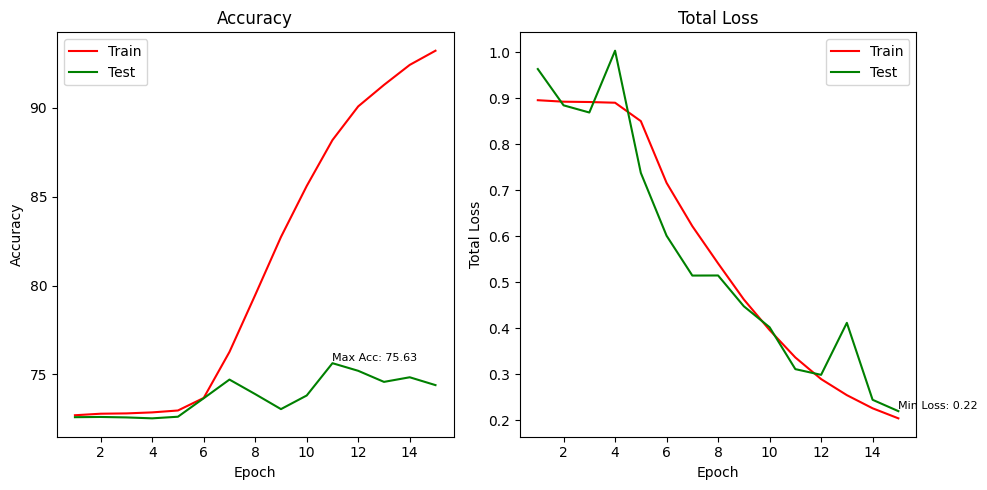

In [ ]:
info_to_plot([acc_history, loss_history], NUM_EPOCHS-1)

### LSTM - TWO LAYERS

In [ ]:
LEARNING_RATE = 0.001
NUM_LAYERS = 2

NUM_CLASSES = 5

model = LSTM(input_dim=len(vocab),
             embedding_dim=EMBEDDING_DIM,
             hidden_dim=HIDDEN_DIM,
             output_dim=NUM_CLASSES, #5
             num_layers=NUM_LAYERS
)

model = model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

acc_history, loss_history = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=DEVICE,
    logging_interval=100)

<ipython-input-41-b0bd7b427bc7>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  text = torch.tensor(text, dtype=torch.long).clone().detach()


Epoch: 001/015 | Batch 0000/0963 | Loss: 1.6393
Epoch: 001/015 | Batch 0100/0963 | Loss: 0.8691
Epoch: 001/015 | Batch 0200/0963 | Loss: 0.7243
Epoch: 001/015 | Batch 0300/0963 | Loss: 1.0333
Epoch: 001/015 | Batch 0400/0963 | Loss: 0.7670
Epoch: 001/015 | Batch 0500/0963 | Loss: 0.8962
Epoch: 001/015 | Batch 0600/0963 | Loss: 1.1255
Epoch: 001/015 | Batch 0700/0963 | Loss: 0.8591
Epoch: 001/015 | Batch 0800/0963 | Loss: 0.8132
Epoch: 001/015 | Batch 0900/0963 | Loss: 1.0816
Epoch: 001/015 | Train: 72.73% | Validation: 72.60%
Time elapsed: 1.85 min
Epoch: 002/015 | Batch 0000/0963 | Loss: 1.0473
Epoch: 002/015 | Batch 0100/0963 | Loss: 1.0166
Epoch: 002/015 | Batch 0200/0963 | Loss: 0.6871
Epoch: 002/015 | Batch 0300/0963 | Loss: 0.9469
Epoch: 002/015 | Batch 0400/0963 | Loss: 0.7279
Epoch: 002/015 | Batch 0500/0963 | Loss: 0.8301
Epoch: 002/015 | Batch 0600/0963 | Loss: 0.9685
Epoch: 002/015 | Batch 0700/0963 | Loss: 0.9087
Epoch: 002/015 | Batch 0800/0963 | Loss: 0.9138
Epoch: 002/01

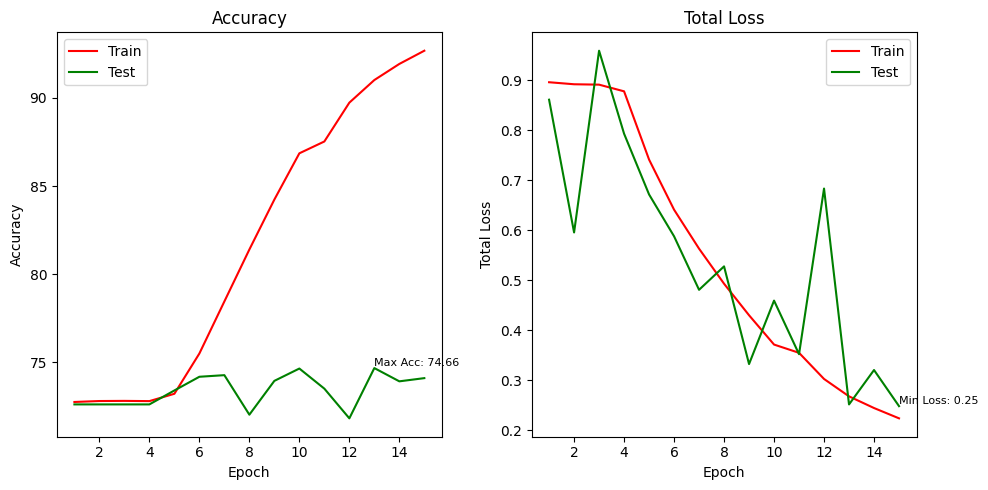

In [ ]:
info_to_plot(result=[acc_history, loss_history], epoch=NUM_EPOCHS-1)

### LSTM - THREE LAYERS

In [ ]:
LEARNING_RATE = 0.001
NUM_LAYERS = 3


model = LSTM(input_dim=len(vocab),
             embedding_dim=EMBEDDING_DIM,
             hidden_dim=HIDDEN_DIM,
             output_dim=NUM_CLASSES, #5
             num_layers=NUM_LAYERS
)

model = model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

acc_history, loss_history = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=DEVICE,
    logging_interval=100)

Epoch: 001/015 | Batch 0000/0963 | Loss: 1.5970
Epoch: 001/015 | Batch 0100/0963 | Loss: 0.7943
Epoch: 001/015 | Batch 0200/0963 | Loss: 0.8294
Epoch: 001/015 | Batch 0300/0963 | Loss: 0.7947
Epoch: 001/015 | Batch 0400/0963 | Loss: 0.8399
Epoch: 001/015 | Batch 0500/0963 | Loss: 0.9303
Epoch: 001/015 | Batch 0600/0963 | Loss: 0.9851
Epoch: 001/015 | Batch 0700/0963 | Loss: 0.9297
Epoch: 001/015 | Batch 0800/0963 | Loss: 0.8244
Epoch: 001/015 | Batch 0900/0963 | Loss: 1.2529
Epoch: 001/015 | Train: 72.78% | Validation: 72.60%
Time elapsed: 2.87 min
Epoch: 002/015 | Batch 0000/0963 | Loss: 0.8489
Epoch: 002/015 | Batch 0100/0963 | Loss: 1.0527
Epoch: 002/015 | Batch 0200/0963 | Loss: 0.7912
Epoch: 002/015 | Batch 0300/0963 | Loss: 0.9974
Epoch: 002/015 | Batch 0400/0963 | Loss: 0.7355
Epoch: 002/015 | Batch 0500/0963 | Loss: 1.0479
Epoch: 002/015 | Batch 0600/0963 | Loss: 1.0825
Epoch: 002/015 | Batch 0700/0963 | Loss: 0.6756
Epoch: 002/015 | Batch 0800/0963 | Loss: 0.8040
Epoch: 002/01

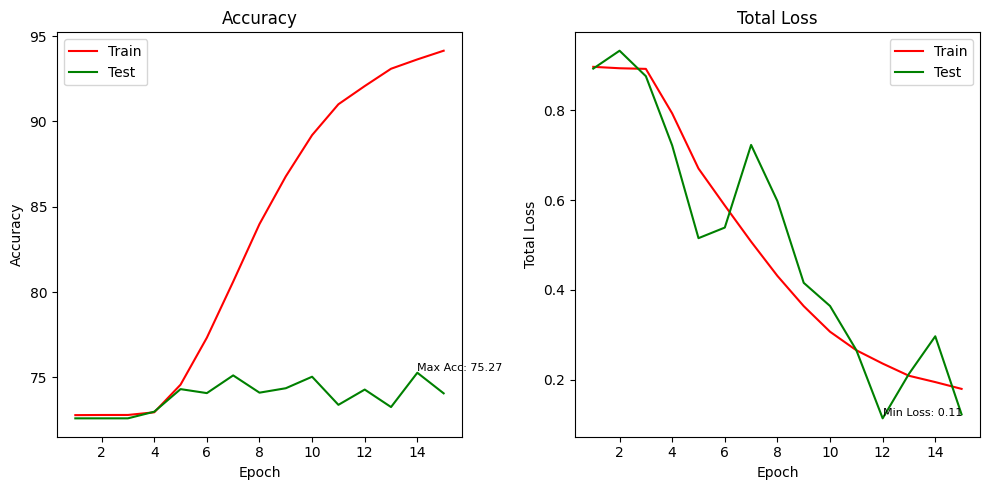

In [ ]:
info_to_plot(result=[acc_history, loss_history], epoch=NUM_EPOCHS-1)

### RNN - ONE LAYER

In [ ]:
LEARNING_RATE = 0.0005
NUM_LAYERS = 1

model = RNN(input_dim=len(vocab),
             embedding_dim=EMBEDDING_DIM,
             hidden_dim=HIDDEN_DIM,
             output_dim=NUM_CLASSES, #5
             num_layers=NUM_LAYERS
)

model = model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

acc_history, loss_history = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=DEVICE,
    logging_interval=100)

<ipython-input-48-20b15ae9468d>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  text = torch.tensor(text, dtype=torch.long).clone().detach()


Epoch: 001/015 | Batch 0000/0963 | Loss: 1.5525
Epoch: 001/015 | Batch 0100/0963 | Loss: 0.9908
Epoch: 001/015 | Batch 0200/0963 | Loss: 0.8791
Epoch: 001/015 | Batch 0300/0963 | Loss: 0.6763
Epoch: 001/015 | Batch 0400/0963 | Loss: 1.1206
Epoch: 001/015 | Batch 0500/0963 | Loss: 0.9484
Epoch: 001/015 | Batch 0600/0963 | Loss: 0.9425
Epoch: 001/015 | Batch 0700/0963 | Loss: 0.8989
Epoch: 001/015 | Batch 0800/0963 | Loss: 0.8070
Epoch: 001/015 | Batch 0900/0963 | Loss: 0.9796
Epoch: 001/015 | Train: 72.79% | Validation: 72.58%
Time elapsed: 0.47 min
Epoch: 002/015 | Batch 0000/0963 | Loss: 0.7610
Epoch: 002/015 | Batch 0100/0963 | Loss: 0.8194
Epoch: 002/015 | Batch 0200/0963 | Loss: 0.6716
Epoch: 002/015 | Batch 0300/0963 | Loss: 1.0813
Epoch: 002/015 | Batch 0400/0963 | Loss: 0.8828
Epoch: 002/015 | Batch 0500/0963 | Loss: 0.7990
Epoch: 002/015 | Batch 0600/0963 | Loss: 0.9673
Epoch: 002/015 | Batch 0700/0963 | Loss: 0.6653
Epoch: 002/015 | Batch 0800/0963 | Loss: 0.7484
Epoch: 002/01

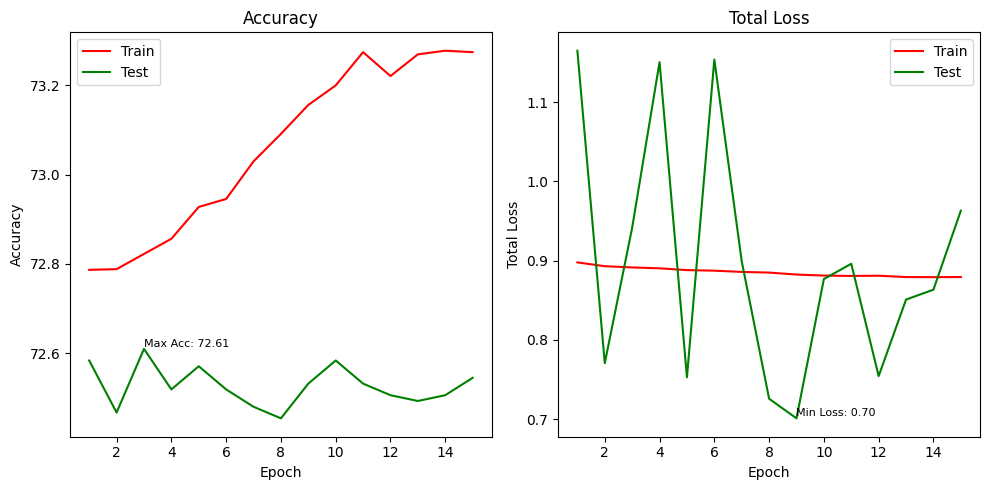

In [ ]:
info_to_plot([acc_history, loss_history], NUM_EPOCHS-1)

### RNN - TWO LAYER

In [ ]:
LEARNING_RATE = 0.001
NUM_LAYERS =2

model = RNN(input_dim=len(vocab),
             embedding_dim=EMBEDDING_DIM,
             hidden_dim=HIDDEN_DIM,
             output_dim=NUM_CLASSES, #5
             num_layers=NUM_LAYERS
)

model = model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

acc_history, loss_history = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=DEVICE,
    logging_interval=100)

<ipython-input-48-20b15ae9468d>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  text = torch.tensor(text, dtype=torch.long).clone().detach()


Epoch: 001/015 | Batch 0000/0963 | Loss: 1.6110
Epoch: 001/015 | Batch 0100/0963 | Loss: 0.6482
Epoch: 001/015 | Batch 0200/0963 | Loss: 0.9158
Epoch: 001/015 | Batch 0300/0963 | Loss: 0.9060
Epoch: 001/015 | Batch 0400/0963 | Loss: 0.9892
Epoch: 001/015 | Batch 0500/0963 | Loss: 0.7186
Epoch: 001/015 | Batch 0600/0963 | Loss: 1.0109
Epoch: 001/015 | Batch 0700/0963 | Loss: 0.8373
Epoch: 001/015 | Batch 0800/0963 | Loss: 0.9129
Epoch: 001/015 | Batch 0900/0963 | Loss: 0.7905
Epoch: 001/015 | Train: 72.74% | Validation: 72.60%
Time elapsed: 0.67 min
Epoch: 002/015 | Batch 0000/0963 | Loss: 0.6527
Epoch: 002/015 | Batch 0100/0963 | Loss: 0.8363
Epoch: 002/015 | Batch 0200/0963 | Loss: 1.0239
Epoch: 002/015 | Batch 0300/0963 | Loss: 0.8558
Epoch: 002/015 | Batch 0400/0963 | Loss: 0.9687
Epoch: 002/015 | Batch 0500/0963 | Loss: 1.0336
Epoch: 002/015 | Batch 0600/0963 | Loss: 0.8352
Epoch: 002/015 | Batch 0700/0963 | Loss: 1.0062
Epoch: 002/015 | Batch 0800/0963 | Loss: 1.0808
Epoch: 002/01

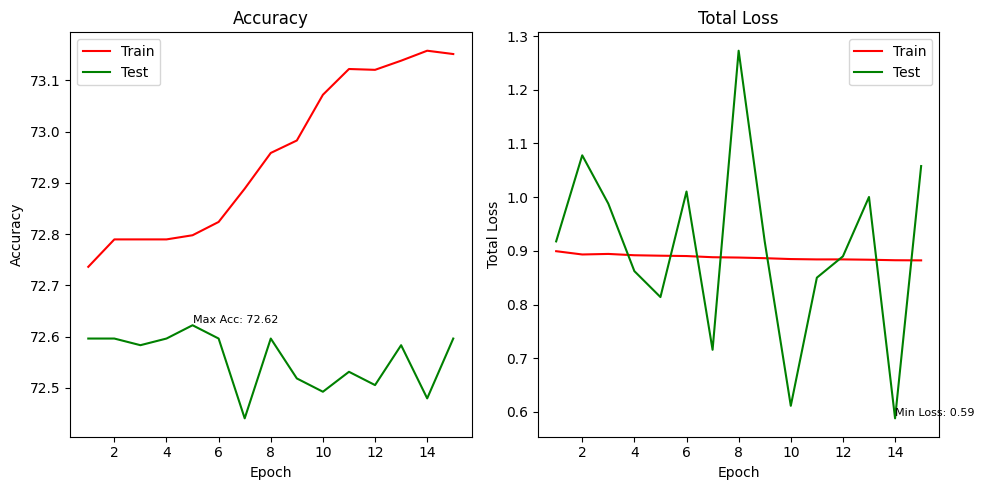

In [ ]:
info_to_plot([acc_history, loss_history], NUM_EPOCHS-1)

### RNN - THREE LAYER

In [ ]:
LEARNING_RATE = 0.001
NUM_LAYERS = 3

model = RNN(input_dim=len(vocab),
             embedding_dim=EMBEDDING_DIM,
             hidden_dim=HIDDEN_DIM,
             output_dim=NUM_CLASSES, #5
             num_layers=NUM_LAYERS
)

model = model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

acc_history, loss_history = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=DEVICE,
    logging_interval=100)

Epoch: 001/015 | Batch 0000/0963 | Loss: 1.5580
Epoch: 001/015 | Batch 0100/0963 | Loss: 0.6973
Epoch: 001/015 | Batch 0200/0963 | Loss: 0.8577
Epoch: 001/015 | Batch 0300/0963 | Loss: 0.9917
Epoch: 001/015 | Batch 0400/0963 | Loss: 1.0416
Epoch: 001/015 | Batch 0500/0963 | Loss: 1.1806
Epoch: 001/015 | Batch 0600/0963 | Loss: 0.9131
Epoch: 001/015 | Batch 0700/0963 | Loss: 1.0683
Epoch: 001/015 | Batch 0800/0963 | Loss: 0.9227
Epoch: 001/015 | Batch 0900/0963 | Loss: 0.6083
Epoch: 001/015 | Train: 72.79% | Validation: 72.60%
Time elapsed: 0.96 min
Epoch: 002/015 | Batch 0000/0963 | Loss: 0.8709
Epoch: 002/015 | Batch 0100/0963 | Loss: 0.9217
Epoch: 002/015 | Batch 0200/0963 | Loss: 0.9912
Epoch: 002/015 | Batch 0300/0963 | Loss: 0.6461
Epoch: 002/015 | Batch 0400/0963 | Loss: 0.9959
Epoch: 002/015 | Batch 0500/0963 | Loss: 0.7644
Epoch: 002/015 | Batch 0600/0963 | Loss: 0.9616
Epoch: 002/015 | Batch 0700/0963 | Loss: 0.7506
Epoch: 002/015 | Batch 0800/0963 | Loss: 0.8829
Epoch: 002/01

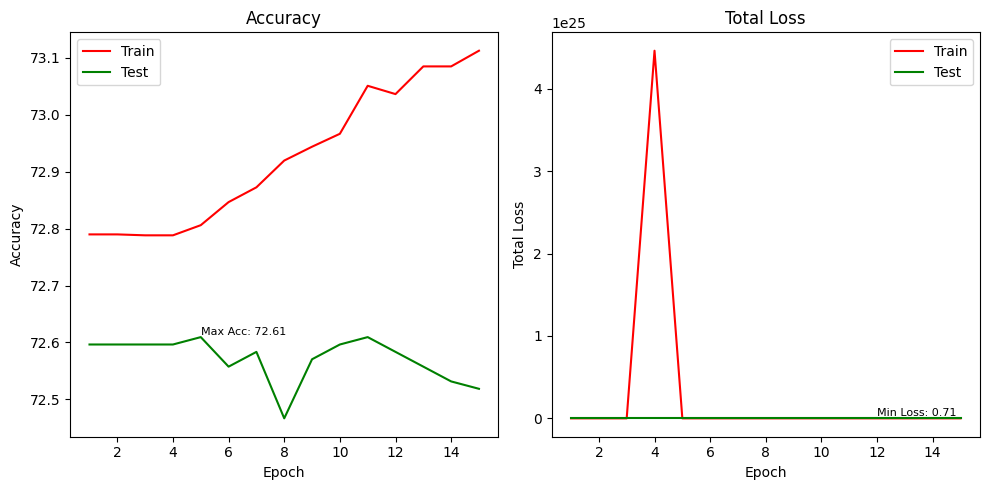

In [ ]:
info_to_plot([acc_history, loss_history], NUM_EPOCHS-1)

### GRU - ONE LAYER

In [ ]:
LEARNING_RATE = 0.001
NUM_LAYERS = 1

model = GRU(input_dim=len(vocab),
             embedding_dim=EMBEDDING_DIM,
             hidden_dim=HIDDEN_DIM,
             output_dim=NUM_CLASSES, #5
             num_layers=NUM_LAYERS
)

model = model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

acc_history, loss_history = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=DEVICE,
    logging_interval=100)

<ipython-input-27-1066645b7dab>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  text = torch.tensor(text, dtype=torch.long).clone().detach()


Epoch: 001/015 | Batch 0000/0963 | Loss: 1.4634
Epoch: 001/015 | Batch 0100/0963 | Loss: 0.7895
Epoch: 001/015 | Batch 0200/0963 | Loss: 0.9546
Epoch: 001/015 | Batch 0300/0963 | Loss: 0.9882
Epoch: 001/015 | Batch 0400/0963 | Loss: 1.0926
Epoch: 001/015 | Batch 0500/0963 | Loss: 0.7506
Epoch: 001/015 | Batch 0600/0963 | Loss: 0.6162
Epoch: 001/015 | Batch 0700/0963 | Loss: 0.5581
Epoch: 001/015 | Batch 0800/0963 | Loss: 0.7919
Epoch: 001/015 | Batch 0900/0963 | Loss: 0.9284
Epoch: 001/015 | Train: 72.87% | Validation: 73.27%
Time elapsed: 0.96 min
Epoch: 002/015 | Batch 0000/0963 | Loss: 0.6693
Epoch: 002/015 | Batch 0100/0963 | Loss: 0.5207
Epoch: 002/015 | Batch 0200/0963 | Loss: 0.4852
Epoch: 002/015 | Batch 0300/0963 | Loss: 0.5868
Epoch: 002/015 | Batch 0400/0963 | Loss: 0.7989
Epoch: 002/015 | Batch 0500/0963 | Loss: 0.6153
Epoch: 002/015 | Batch 0600/0963 | Loss: 0.5246
Epoch: 002/015 | Batch 0700/0963 | Loss: 0.6660
Epoch: 002/015 | Batch 0800/0963 | Loss: 0.4995
Epoch: 002/01

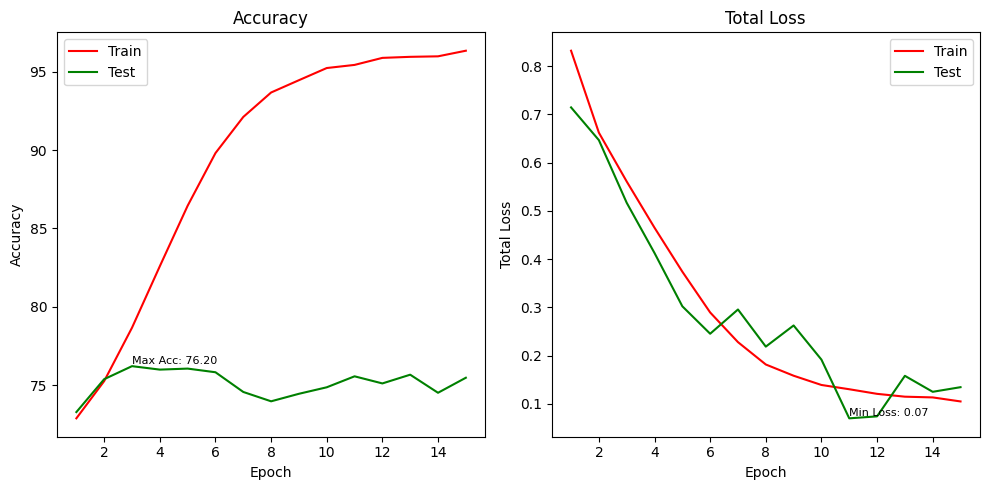

In [ ]:
info_to_plot([acc_history, loss_history], NUM_EPOCHS-1)

### GRU - TWO LAYER

In [ ]:
LEARNING_RATE = 0.001
NUM_LAYERS = 2

model = GRU(input_dim=len(vocab),
             embedding_dim=EMBEDDING_DIM,
             hidden_dim=HIDDEN_DIM,
             output_dim=NUM_CLASSES, #5
             num_layers=NUM_LAYERS
)

model = model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

acc_history, loss_history = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=DEVICE,
    logging_interval=100)

<ipython-input-34-1066645b7dab>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  text = torch.tensor(text, dtype=torch.long).clone().detach()


Epoch: 001/015 | Batch 0000/0963 | Loss: 1.5458
Epoch: 001/015 | Batch 0100/0963 | Loss: 1.0816
Epoch: 001/015 | Batch 0200/0963 | Loss: 0.7120
Epoch: 001/015 | Batch 0300/0963 | Loss: 0.8625
Epoch: 001/015 | Batch 0400/0963 | Loss: 0.8260
Epoch: 001/015 | Batch 0500/0963 | Loss: 0.8703
Epoch: 001/015 | Batch 0600/0963 | Loss: 0.7425
Epoch: 001/015 | Batch 0700/0963 | Loss: 0.8771
Epoch: 001/015 | Batch 0800/0963 | Loss: 0.6016
Epoch: 001/015 | Batch 0900/0963 | Loss: 0.7322
Epoch: 001/015 | Train: 73.14% | Validation: 74.08%
Time elapsed: 1.60 min
Epoch: 002/015 | Batch 0000/0963 | Loss: 0.6591
Epoch: 002/015 | Batch 0100/0963 | Loss: 0.8424
Epoch: 002/015 | Batch 0200/0963 | Loss: 0.9069
Epoch: 002/015 | Batch 0300/0963 | Loss: 0.5379
Epoch: 002/015 | Batch 0400/0963 | Loss: 0.4949
Epoch: 002/015 | Batch 0500/0963 | Loss: 0.6302
Epoch: 002/015 | Batch 0600/0963 | Loss: 0.6732
Epoch: 002/015 | Batch 0700/0963 | Loss: 0.7212
Epoch: 002/015 | Batch 0800/0963 | Loss: 0.7292
Epoch: 002/01

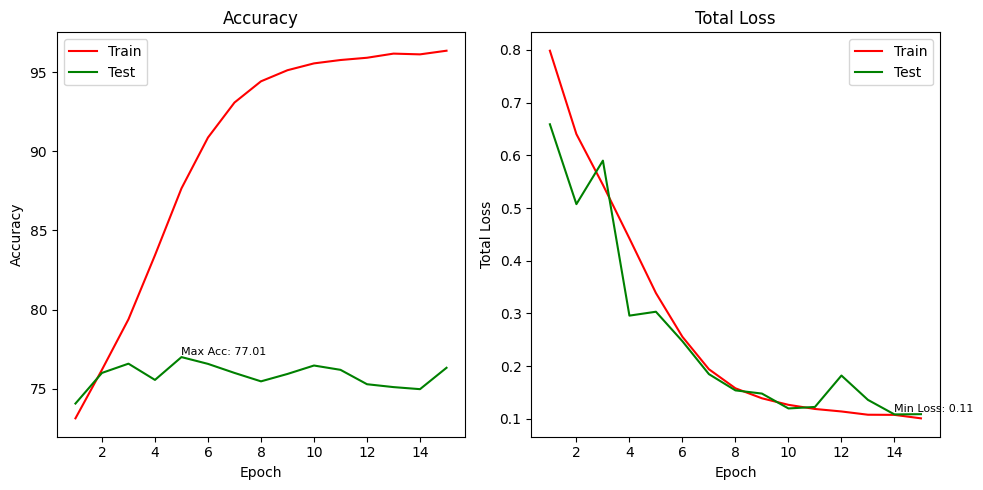

In [ ]:
info_to_plot([acc_history, loss_history], NUM_EPOCHS-1)

### GRU - THREE LAYER

In [ ]:
LEARNING_RATE = 0.001
NUM_LAYERS = 3

model = GRU(input_dim=len(vocab),
             embedding_dim=EMBEDDING_DIM,
             hidden_dim=HIDDEN_DIM,
             output_dim=NUM_CLASSES, #5
             num_layers=NUM_LAYERS
)

model = model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

acc_history, loss_history = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=DEVICE,
    logging_interval=100)

<ipython-input-31-1066645b7dab>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  text = torch.tensor(text, dtype=torch.long).clone().detach()


Epoch: 001/015 | Batch 0000/0963 | Loss: 1.6947
Epoch: 001/015 | Batch 0100/0963 | Loss: 1.1089
Epoch: 001/015 | Batch 0200/0963 | Loss: 0.9238
Epoch: 001/015 | Batch 0300/0963 | Loss: 0.7965
Epoch: 001/015 | Batch 0400/0963 | Loss: 0.9593
Epoch: 001/015 | Batch 0500/0963 | Loss: 0.8358
Epoch: 001/015 | Batch 0600/0963 | Loss: 0.5113
Epoch: 001/015 | Batch 0700/0963 | Loss: 0.7557
Epoch: 001/015 | Batch 0800/0963 | Loss: 0.7149
Epoch: 001/015 | Batch 0900/0963 | Loss: 0.7009
Epoch: 001/015 | Train: 72.93% | Validation: 73.91%
Time elapsed: 2.26 min
Epoch: 002/015 | Batch 0000/0963 | Loss: 0.7482
Epoch: 002/015 | Batch 0100/0963 | Loss: 0.5745
Epoch: 002/015 | Batch 0200/0963 | Loss: 0.6203
Epoch: 002/015 | Batch 0300/0963 | Loss: 0.4737
Epoch: 002/015 | Batch 0400/0963 | Loss: 0.7284
Epoch: 002/015 | Batch 0500/0963 | Loss: 0.8664
Epoch: 002/015 | Batch 0600/0963 | Loss: 0.5866
Epoch: 002/015 | Batch 0700/0963 | Loss: 0.5953
Epoch: 002/015 | Batch 0800/0963 | Loss: 0.7669
Epoch: 002/01

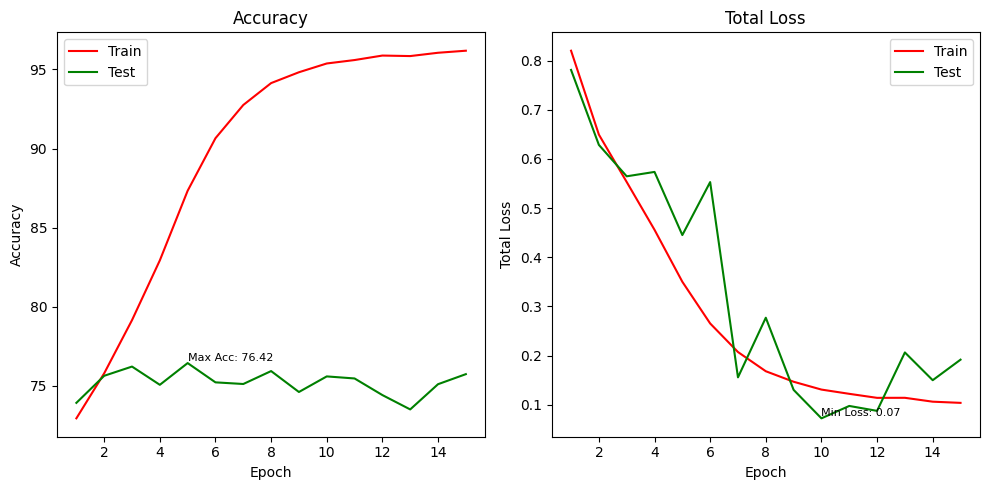

In [ ]:
info_to_plot([acc_history, loss_history], NUM_EPOCHS-1)

# Part B - Train Models for Amazon Review Dataset without Two Classes

*   Train the Network with Amazon Review Dataset expext classes two and four
*   Evaluation on class two and four of Amazon Dataset
*   Evaluation on IMDB Dataset




In [ ]:
print(list(train_dp)[0])

['1', 'Fast cutting and good adheasive.', '4']


## Update Train and Test Data Pipe

In [ ]:
train_dp = [data_item for data_item in train_dp if data_item[2] != '1' and data_item[2] != '3']
valid_dp = [data_item for data_item in valid_dp if data_item[2] == '1' or data_item[2] == '3']
test_dp = [data_item for data_item in test_dp if data_item[2] == '1' or data_item[2] == '3']

In [ ]:
print(len(train_dp))
print(len(valid_dp))
print(len(test_dp))

50442
1417
1365


## Build the New Vocab

In [ ]:
vocab = get_vocab(train_dp)
PADDING_VALUE=vocab['<PAD>']
vocab_itos = vocab.get_itos()
vec_vocab_itos = np.vectorize(lambda x: vocab_itos[x])
text_transform = lambda x: [vocab[token] for token in tokenizer(x)]
label_transform = lambda x: int(x)

## Data Loader

In [ ]:
train_loader = DataLoader(train_dp,
                          batch_sampler=BatchSamplerSimilarLength(dataset = train_dp,
                                                                  batch_size=BATCH_SIZE),
                          collate_fn=collate_batch)
valid_loader = DataLoader(valid_dp,
                          batch_sampler=BatchSamplerSimilarLength(dataset = valid_dp,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=False),
                          collate_fn=collate_batch)
test_loader = DataLoader(test_dp,
                          batch_sampler=BatchSamplerSimilarLength(dataset = test_dp,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=False),
                          collate_fn=collate_batch)

In [ ]:
text_batch, label_batch = next(iter(train_loader))
print(text_batch.size())
print(label_batch.size())

torch.Size([271, 64])
torch.Size([64])


In [ ]:
print('Train')
for text_batch, label_batch in train_loader:
    print(f'Text matrix size: {text_batch.size()}')
    print(f'Target vector size: {label_batch.size()}')
    break

print('\nValid:')
for text_batch, label_batch in valid_loader:
    print(f'Text matrix size: {text_batch.size()}')
    print(f'Target vector size: {label_batch.size()}')
    break

print('\nTest:')
for text_batch, label_batch in test_loader:
    print(f'Text matrix size: {text_batch.size()}')
    print(f'Target vector size: {label_batch.size()}')
    break

Train
Text matrix size: torch.Size([702, 64])
Target vector size: torch.Size([64])

Valid:
Text matrix size: torch.Size([804, 64])
Target vector size: torch.Size([64])

Test:
Text matrix size: torch.Size([262, 64])
Target vector size: torch.Size([64])


## Train Model

In [ ]:
LEARNING_RATE = 0.001
NUM_LAYERS = 2
NUM_EPOCHS = 4


model = GRU(input_dim=len(vocab),
             embedding_dim=EMBEDDING_DIM,
             hidden_dim=HIDDEN_DIM,
             output_dim=NUM_CLASSES, #5
             num_layers=NUM_LAYERS
)

model = model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

acc_history, loss_history = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=DEVICE,
    logging_interval=100,
    save_model=True)

Epoch: 001/004 | Batch 0000/0788 | Loss: 1.5838
Epoch: 001/004 | Batch 0100/0788 | Loss: 0.5874
Epoch: 001/004 | Batch 0200/0788 | Loss: 0.3892
Epoch: 001/004 | Batch 0300/0788 | Loss: 0.3885
Epoch: 001/004 | Batch 0400/0788 | Loss: 0.2156
Epoch: 001/004 | Batch 0500/0788 | Loss: 0.1847
Epoch: 001/004 | Batch 0600/0788 | Loss: 0.4333
Epoch: 001/004 | Batch 0700/0788 | Loss: 0.4881
Epoch: 001/004 | Train: 89.19% | Validation: 0.00%
Time elapsed: 1.19 min
Epoch: 002/004 | Batch 0000/0788 | Loss: 0.4337
Epoch: 002/004 | Batch 0100/0788 | Loss: 0.2852
Epoch: 002/004 | Batch 0200/0788 | Loss: 0.2096
Epoch: 002/004 | Batch 0300/0788 | Loss: 0.2020
Epoch: 002/004 | Batch 0400/0788 | Loss: 0.1105
Epoch: 002/004 | Batch 0500/0788 | Loss: 0.3155
Epoch: 002/004 | Batch 0600/0788 | Loss: 0.1330
Epoch: 002/004 | Batch 0700/0788 | Loss: 0.1270
Epoch: 002/004 | Train: 91.97% | Validation: 0.00%
Time elapsed: 2.42 min
Epoch: 003/004 | Batch 0000/0788 | Loss: 0.1599
Epoch: 003/004 | Batch 0100/0788 | L

## Results

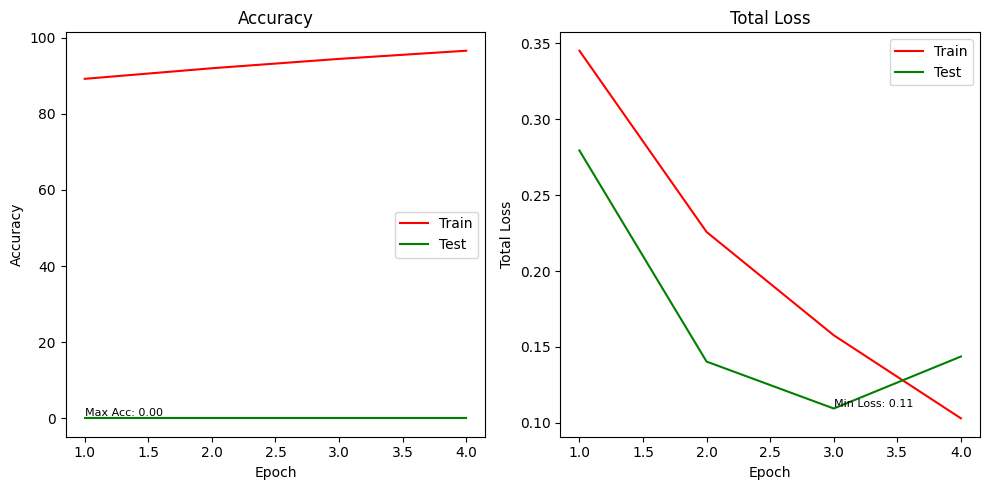

In [ ]:
info_to_plot([acc_history, loss_history], NUM_EPOCHS-1)

# Part B - Evaluation on the IMDB Dataset

## Load Model

In [ ]:
model_checkpoint_path = '/content/drive/MyDrive/Neural_Network/HW5/saved_models/model_best_accuracy.pt'
checkpoint = torch.load(model_checkpoint_path, map_location=torch.device(DEVICE))

epoch_num = checkpoint['epoch']
accuracy = checkpoint['accuracy']
NUM_LAYERS = 2
model = GRU(input_dim=len(vocab),
             embedding_dim=EMBEDDING_DIM,
             hidden_dim=HIDDEN_DIM,
             output_dim=NUM_CLASSES, #5
             num_layers=NUM_LAYERS
)

print("Epoch Number:", epoch_num)
print("Test Accuracy: ", accuracy)

Epoch Number: 3
Test Accuracy:  0.0


## Load Dataset

In [ ]:
datapipe = IterableWrapper(["IMDB Dataset.csv"])
datapipe = FileOpener(datapipe, mode='b')
datapipe = datapipe.parse_csv(skip_lines=1)

In [ ]:
print(list(datapipe)[0])

["One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the f

In [ ]:
# Get the number of rows in dataset
N_ROWS = len(list(datapipe))
print(N_ROWS)

# Split into training and val datapipes early on. Will build vocabulary from training datapipe only.
train_dp, test_dp = datapipe.random_split(total_length=N_ROWS, weights={"train": 0.9, "test": 0.1}, seed=0)
print(f'Num Train: {len(list(train_dp))}')
print(f'Num Test: {len(list(test_dp))}')

50000
Num Train: 45000
Num Test: 5000


In [ ]:
# Based on tutorial at https://www.youtube.com/watch?v=CrS-LFXEiyk
tokenizer = get_tokenizer(tokenizer='spacy', language='en_core_web_sm')

def yield_tokens(data_iter):
    for text , _ in data_iter:
        yield tokenizer(text)

def get_vocab(train_datapipe):
    vocab = build_vocab_from_iterator(yield_tokens(train_datapipe), specials=["<UNK>", "<PAD>"], max_tokens=VOCABULARY_SIZE)
    vocab.set_default_index(vocab["<UNK>"])
    return vocab

In [ ]:
vocab = get_vocab(test_dp)
PADDING_VALUE=vocab['<PAD>']

text_transform = lambda x: [vocab[token] for token in tokenizer(x)]
# Define label_transform of the IMDB Dataset as "negative" = 0 & "positive" = 1
label_transform = lambda x: 0 if x == 'negative' else 1

In [ ]:
vocab_itos = vocab.get_itos()
vec_vocab_itos = np.vectorize(lambda x: vocab_itos[x])

In [ ]:
def collate_batch(batch):
   text_list, label_list = [], []
   for (_text, _label) in batch:
        processed_text = torch.tensor(text_transform(_text))
        text_list.append(processed_text)
        label_list.append(label_transform(_label))
   return pad_sequence(text_list, padding_value=PADDING_VALUE).to(DEVICE), torch.tensor(label_list).to(DEVICE)

In [ ]:
class BatchSamplerSimilarLength(Sampler):
    def __init__(self, dataset, batch_size, indices=None, shuffle=True):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = [(i, len(tokenizer(s[0]))) for i, s in enumerate(dataset)]
        if indices is not None:
            self.indices = torch.tensor(self.indices)[indices].tolist()

    def __iter__(self):
        if self.shuffle:
            random.shuffle(self.indices)

        pooled_indices = []
        # create pool of indices with similar lengths
        for i in range(0, len(self.indices), self.batch_size * 100):
          pooled_indices.extend(sorted(self.indices[i:i + self.batch_size * 100], key=lambda x: x[1]))
        self.pooled_indices = [x[0] for x in pooled_indices]

        # yield indices for current batch
        batches = [self.pooled_indices[i:i + self.batch_size] for i in
                   range(0, len(self.pooled_indices), self.batch_size)]

        if self.shuffle:
            random.shuffle(batches)
        for batch in batches:
            yield batch

    def __len__(self):
        return len(self.pooled_indices) // self.batch_size

In [ ]:
BATCH_SIZE = 30
test_dp = list(test_dp)
test_loader = DataLoader(test_dp,
                          batch_sampler=BatchSamplerSimilarLength(dataset = test_dp,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=True),
                          collate_fn=collate_batch)

## Test on IMDB Dataset

In [ ]:
device = DEVICE
model.eval()
model = model.to(device)
for data, target in test_loader:
      data = data.to(device)
      target = target.to(device)
      model = model.to(device)
      output = model(data)
      _, predicted = torch.max(output.data, 1)
      break

print(target.tolist())
print(predicted.tolist())

[0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 2, 0, 3]
